In [1]:
import os
import torch
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.model_selection import KFold
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [12]:
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
session_ids = [719161530, 750332458, 750749662, 754312389, 755434585, 756029989, 791319847, 797828357]
selected_sessions = {}

for i, session_id in enumerate(session_ids):
    session = cache.get_session_data(session_id)
    selected_sessions[session_id] = session
    print(f'session{session_id}:{session.session_type}')

session719161530:brain_observatory_1.1
session750332458:brain_observatory_1.1
session750749662:brain_observatory_1.1
session754312389:brain_observatory_1.1
session755434585:brain_observatory_1.1
session756029989:brain_observatory_1.1
session791319847:brain_observatory_1.1
session797828357:brain_observatory_1.1


In [3]:
def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

In [4]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']
session = selected_sessions[755434585]
# print(session.metadata)
drift_stim_table = session.get_stimulus_table('drifting_gratings')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,225,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1585.891887,2,drifting_gratings,1587.893537,1,2.00165,246
3799,0.8,270,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1588.894403,2,drifting_gratings,1590.896063,2,2.00166,247
3800,0.8,0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1591.896927,2,drifting_gratings,1593.898597,8,2.00167,248
3801,0.8,0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1594.899423,2,drifting_gratings,1596.901083,2,2.00166,249
3802,0.8,315,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1597.901957,2,drifting_gratings,1599.903567,2,2.00161,250


In [91]:
temp_freq_list = [1.0, 2.0, 4.0, 8.0, 15.0]
ori_list = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]

area_1 = 'VISp'
area_2 = 'VISpm'
area_3 = 'VISam'
ori_response_matrix_1 = {}
ori_response_matrix_2 = {}
ori_response_matrix_3 = {}

for i, ori in enumerate(ori_list):
    stim_table = drift_stim_table[(drift_stim_table['temporal_frequency'] == temp_freq_list[0]) 
                        & (drift_stim_table['orientation'] == ori_list[i])]
    design_matrix_1 = spike_matrix(area_1, stim_table).mean(0)
    ori_response_matrix_1[ori] = design_matrix_1
    design_matrix_2 = spike_matrix(area_2, stim_table).mean(0)
    ori_response_matrix_2[ori] = design_matrix_2
    design_matrix_3 = spike_matrix(area_3, stim_table).mean(0)
    ori_response_matrix_3[ori] = design_matrix_3
    
print(design_matrix_1.shape)
print(design_matrix_2.shape)
print(design_matrix_3.shape)

(20, 75)
(20, 62)
(20, 94)


(8, 20)
(8, 20)
(8, 20)


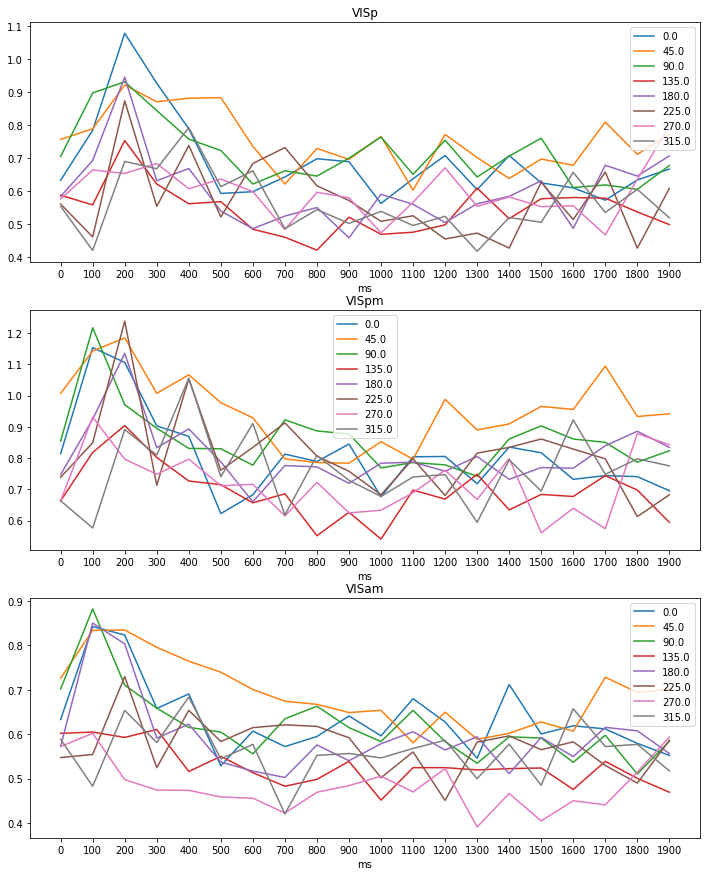

In [92]:
bin = 0.1
period = 2
time_bins = np.arange(0, period, bin)  

ori_response_curve_1 = np.empty([len(ori_list), len(time_bins)])
ori_response_curve_2 = np.empty([len(ori_list), len(time_bins)])
ori_response_curve_3 = np.empty([len(ori_list), len(time_bins)])

for i, ori in enumerate(ori_list):
    ori_response_curve_1[i] = ori_response_matrix_1[ori].mean(1)
    ori_response_curve_2[i] = ori_response_matrix_2[ori].mean(1)
    ori_response_curve_3[i] = ori_response_matrix_3[ori].mean(1)

print(ori_response_curve_1.shape)
print(ori_response_curve_2.shape)
print(ori_response_curve_3.shape)

f, axes = plt.subplots(nrows=3, figsize=(12, 15))

axes[0].plot(ori_response_curve_1.T)
axes[0].legend(ori_list)
axes[0].set_title(area_1)
axes[0].set_xticks(np.arange(len(time_bins)))
axes[0].set_xticklabels(np.arange(len(time_bins))*100)
axes[0].set_xlabel('ms')

axes[1].plot(ori_response_curve_2.T)
axes[1].legend(ori_list)
axes[1].set_title(area_2)
axes[1].set_xticks(np.arange(len(time_bins)))
axes[1].set_xticklabels(np.arange(len(time_bins))*100)
axes[1].set_xlabel('ms')

axes[2].plot(ori_response_curve_3.T)
axes[2].legend(ori_list)
axes[2].set_title(area_3)
axes[2].set_xticks(np.arange(len(time_bins)))
axes[2].set_xticklabels(np.arange(len(time_bins))*100)
axes[2].set_xlabel('ms')

plt.show()

(8,)
(8,)
(8,)


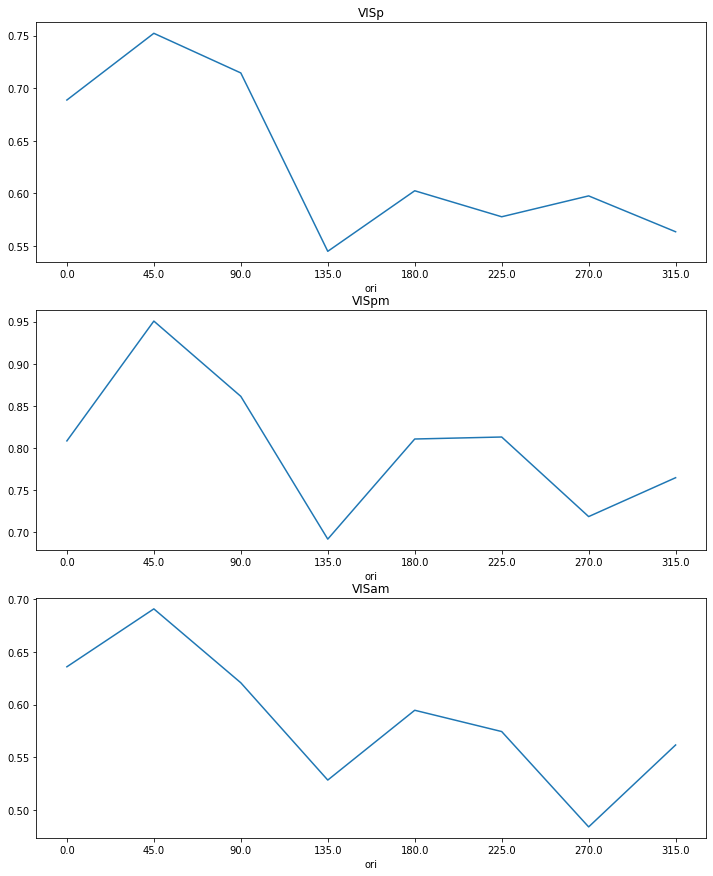

In [93]:
bin = 0.1
period = 2
time_bins = np.arange(0, period, bin)  

ori_tunning_curve_1 = ori_response_curve_1.mean(1)
ori_tunning_curve_2 = ori_response_curve_2.mean(1)
ori_tunning_curve_3 = ori_response_curve_3.mean(1)

print(ori_tunning_curve_1.shape)
print(ori_tunning_curve_2.shape)
print(ori_tunning_curve_3.shape)

f, axes = plt.subplots(nrows=3, figsize=(12, 15))

axes[0].plot(ori_tunning_curve_1)
axes[0].set_xticks(np.arange(len(ori_list)))
axes[0].set_xticklabels(ori_list)
axes[0].set_title(area_1)
axes[0].set_xlabel('ori')

axes[1].plot(ori_tunning_curve_2)
axes[1].set_xticks(np.arange(len(ori_list)))
axes[1].set_xticklabels(ori_list)
axes[1].set_title(area_2)
axes[1].set_xlabel('ori')

axes[2].plot(ori_tunning_curve_3)
axes[2].set_xticks(np.arange(len(ori_list)))
axes[2].set_xticklabels(ori_list)
axes[2].set_title(area_3)
axes[2].set_xlabel('ori')

plt.show()

In [94]:
def corr_area_pairs(X_a, X_b, n_components=3):
    """corr_area_pairs cca between two areas' design matrix, X_a and X_b

    Arguments:
        X_a -- design matrix of one area, shape (stims*bins, units)
        X_b -- design matrix of one area, shape (stims*bins, units)

    Keyword Arguments:
        n_components -- num of canonical dimensions (default: {3})

    Returns:
        corr_z, correlation of latent variables, shape (n_components,)
        w_a, projection matrix used to transform X_a, shape (units_a, n_components)
        w_b, projection matrix used to transform X_b, shape (units_b, n_components) 
        z_a, canonical variables after projection X_a with w_a, shape (n_samples, n_components)
        z_b, canonical variables after projection X_b with w_b, shape (n_samples, n_components)
    """

    cca = CCA(n_components, max_iter=1000)
    cca.fit(X_a, X_b)
    z_a, z_b = cca.transform(X_a, X_b) # latent variables

    # get weight after cca
    w_a = cca.x_rotations_
    w_b = cca.y_rotations_
    
    # get correlation of hidden z
    corr_z = np.empty(n_components)
    for i in range(n_components):
        corr_z[i] = np.corrcoef(z_a[:, i], z_b[:, i])[0, 1]

    return corr_z, (w_a, w_b), (z_a, z_b)

In [95]:
n_components = 10

num_bins_1, num_neurons_1 = ori_response_matrix_1[0.0].shape
num_bins_2, num_neurons_2 = ori_response_matrix_2[0.0].shape
num_bins_3, num_neurons_3 = ori_response_matrix_3[0.0].shape

ori_corr_12 = np.empty([len(ori_list), n_components])
ori_corr_13 = np.empty([len(ori_list), n_components])

ori_w_1_2 = np.empty([len(ori_list), num_neurons_1, n_components])
ori_w_1_3 = np.empty([len(ori_list), num_neurons_1, n_components])
ori_w_2 = np.empty([len(ori_list), num_neurons_2, n_components])
ori_w_3 = np.empty([len(ori_list), num_neurons_3, n_components])

ori_z_1_2 = np.empty([len(ori_list), num_bins_1, n_components])
ori_z_1_3 = np.empty([len(ori_list), num_bins_1, n_components])
ori_z_2 = np.empty([len(ori_list), num_bins_2, n_components])
ori_z_3 = np.empty([len(ori_list), num_bins_3, n_components])

for i, ori in enumerate(ori_list):
    design_matrix_1 = ori_response_matrix_1[ori]
    design_matrix_2 = ori_response_matrix_2[ori]
    design_matrix_3 = ori_response_matrix_3[ori]

    ori_corr_12[i], (ori_w_1_2[i], ori_w_2[i]), (ori_z_1_2[i], ori_z_2[i]) = corr_area_pairs(design_matrix_1, design_matrix_2, n_components)
    ori_corr_13[i], (ori_w_1_3[i], ori_w_3[i]), (ori_z_1_3[i], ori_z_3[i]) = corr_area_pairs(design_matrix_1, design_matrix_3, n_components)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


Text(0, 0.5, 'correlation')

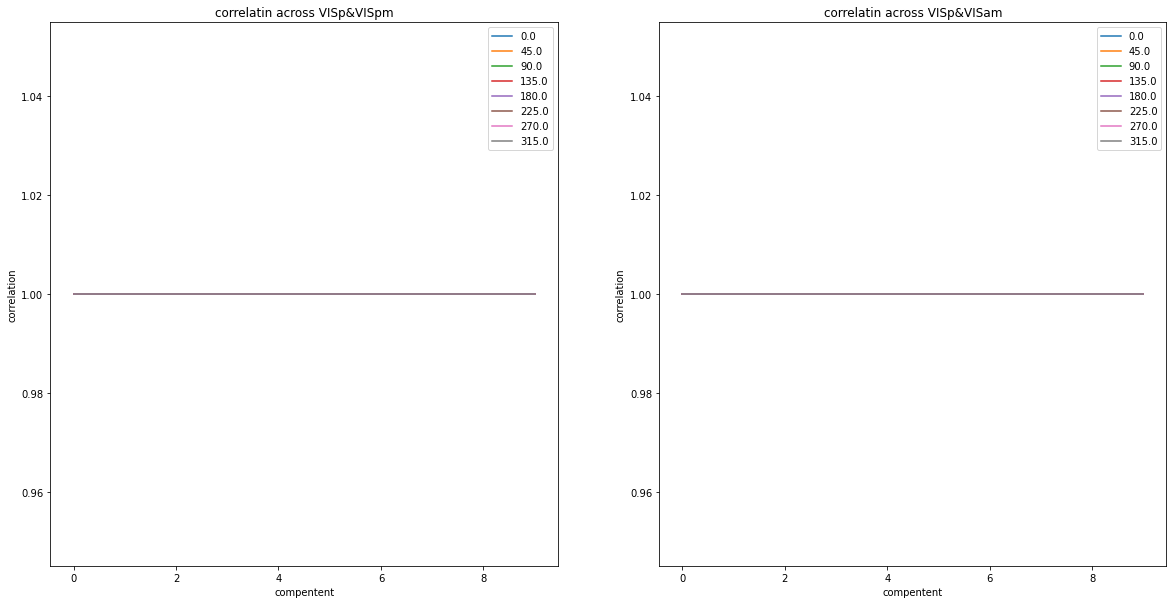

In [96]:
print(ori_corr_12)
print(ori_corr_13)

f, axes = plt.subplots(ncols=2, figsize=(20, 10))

axes[0].plot(ori_corr_12.T)
axes[0].legend(ori_list)
axes[0].set_title(f'correlatin across {area_1}&{area_2}')
axes[0].set_xlabel('compentent')
axes[0].set_ylabel('correlation')

axes[1].plot(ori_corr_13.T)
axes[1].legend(ori_list)
axes[1].set_title(f'correlatin across {area_1}&{area_3}')
axes[1].set_xlabel('compentent')
axes[1].set_ylabel('correlation')

Text(0.5, 0, 'ms')

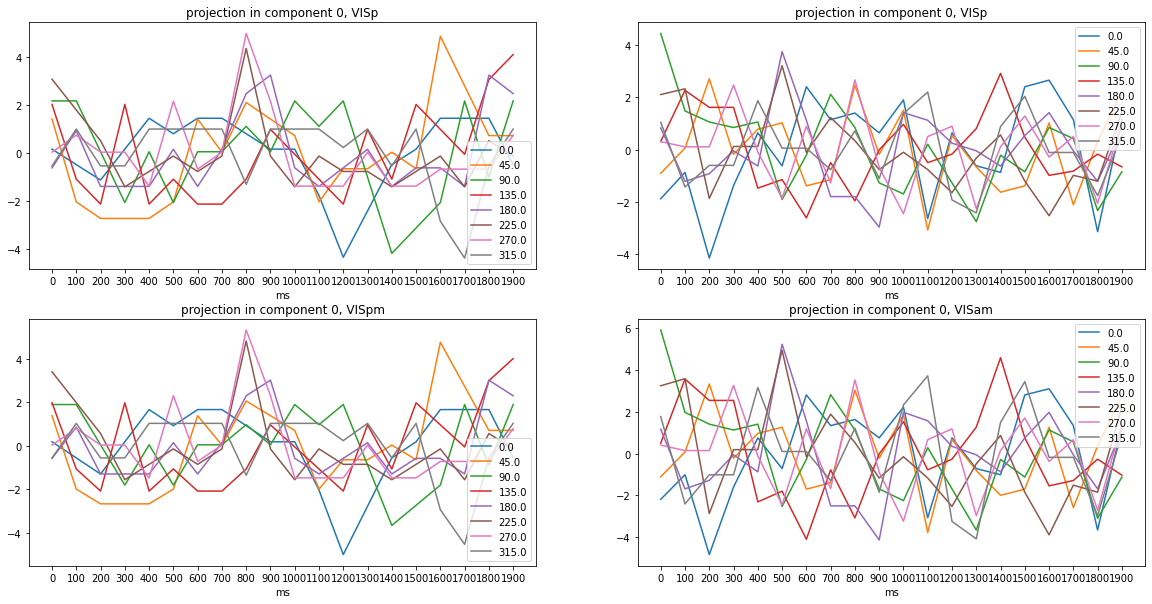

In [97]:
component = 0

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axes[0][0].plot(ori_z_1_2[:, :, component].T)
axes[0][0].legend(ori_list)
axes[0][0].set_title(f'projection in component {component}, {area_1}')
axes[0][0].set_xticks(np.arange(len(time_bins)))
axes[0][0].set_xticklabels(np.arange(len(time_bins))*100)
axes[0][0].set_xlabel('ms')

axes[1][0].plot(ori_z_2[:, :, component].T)
axes[1][0].legend(ori_list)
axes[1][0].set_title(f'projection in component {component}, {area_2}')
axes[1][0].set_xticks(np.arange(len(time_bins)))
axes[1][0].set_xticklabels(np.arange(len(time_bins))*100)
axes[1][0].set_xlabel('ms')

axes[0][1].plot(ori_z_1_3[:, :, component].T)
axes[0][1].legend(ori_list)
axes[0][1].set_title(f'projection in component {component}, {area_1}')
axes[0][1].set_xticks(np.arange(len(time_bins)))
axes[0][1].set_xticklabels(np.arange(len(time_bins))*100)
axes[0][1].set_xlabel('ms')

axes[1][1].plot(ori_z_3[:, :, component].T)
axes[1][1].legend(ori_list)
axes[1][1].set_title(f'projection in component {component}, {area_3}')
axes[1][1].set_xticks(np.arange(len(time_bins)))
axes[1][1].set_xticklabels(np.arange(len(time_bins))*100)
axes[1][1].set_xlabel('ms')

Text(0.5, 0, 'ms')

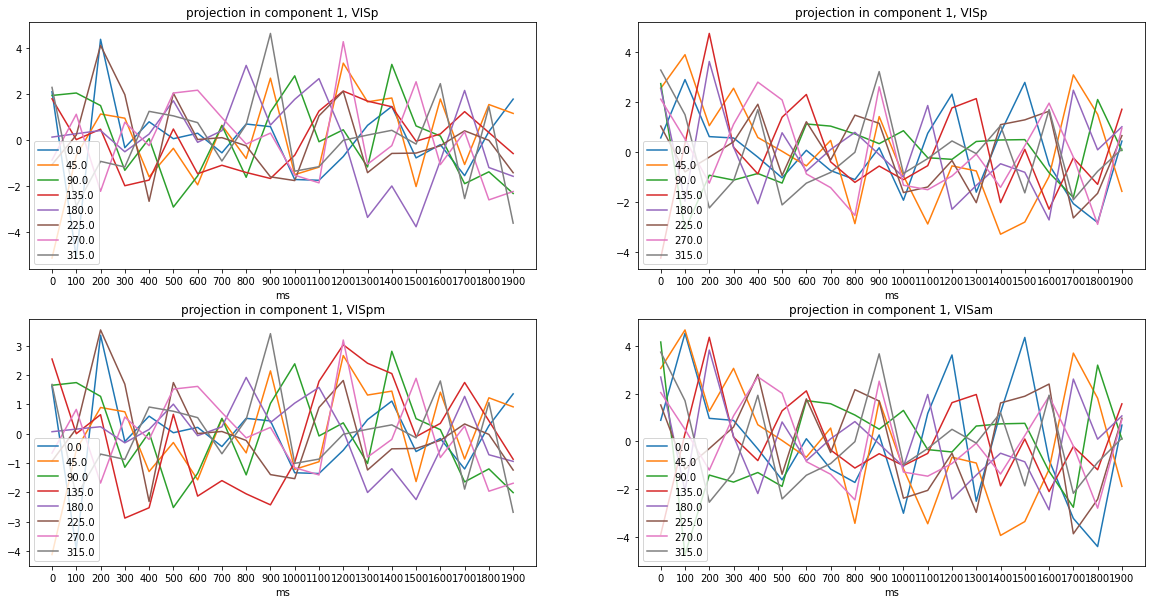

In [100]:
component = 1

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axes[0][0].plot(ori_z_1_2[:, :, component].T)
axes[0][0].legend(ori_list)
axes[0][0].set_title(f'projection in component {component}, {area_1}')
axes[0][0].set_xticks(np.arange(len(time_bins)))
axes[0][0].set_xticklabels(np.arange(len(time_bins))*100)
axes[0][0].set_xlabel('ms')

axes[1][0].plot(ori_z_2[:, :, component].T)
axes[1][0].legend(ori_list)
axes[1][0].set_title(f'projection in component {component}, {area_2}')
axes[1][0].set_xticks(np.arange(len(time_bins)))
axes[1][0].set_xticklabels(np.arange(len(time_bins))*100)
axes[1][0].set_xlabel('ms')

axes[0][1].plot(ori_z_1_3[:, :, component].T)
axes[0][1].legend(ori_list)
axes[0][1].set_title(f'projection in component {component}, {area_1}')
axes[0][1].set_xticks(np.arange(len(time_bins)))
axes[0][1].set_xticklabels(np.arange(len(time_bins))*100)
axes[0][1].set_xlabel('ms')

axes[1][1].plot(ori_z_3[:, :, component].T)
axes[1][1].legend(ori_list)
axes[1][1].set_title(f'projection in component {component}, {area_3}')
axes[1][1].set_xticks(np.arange(len(time_bins)))
axes[1][1].set_xticklabels(np.arange(len(time_bins))*100)
axes[1][1].set_xlabel('ms')

Text(0, 0.5, 'component 1')

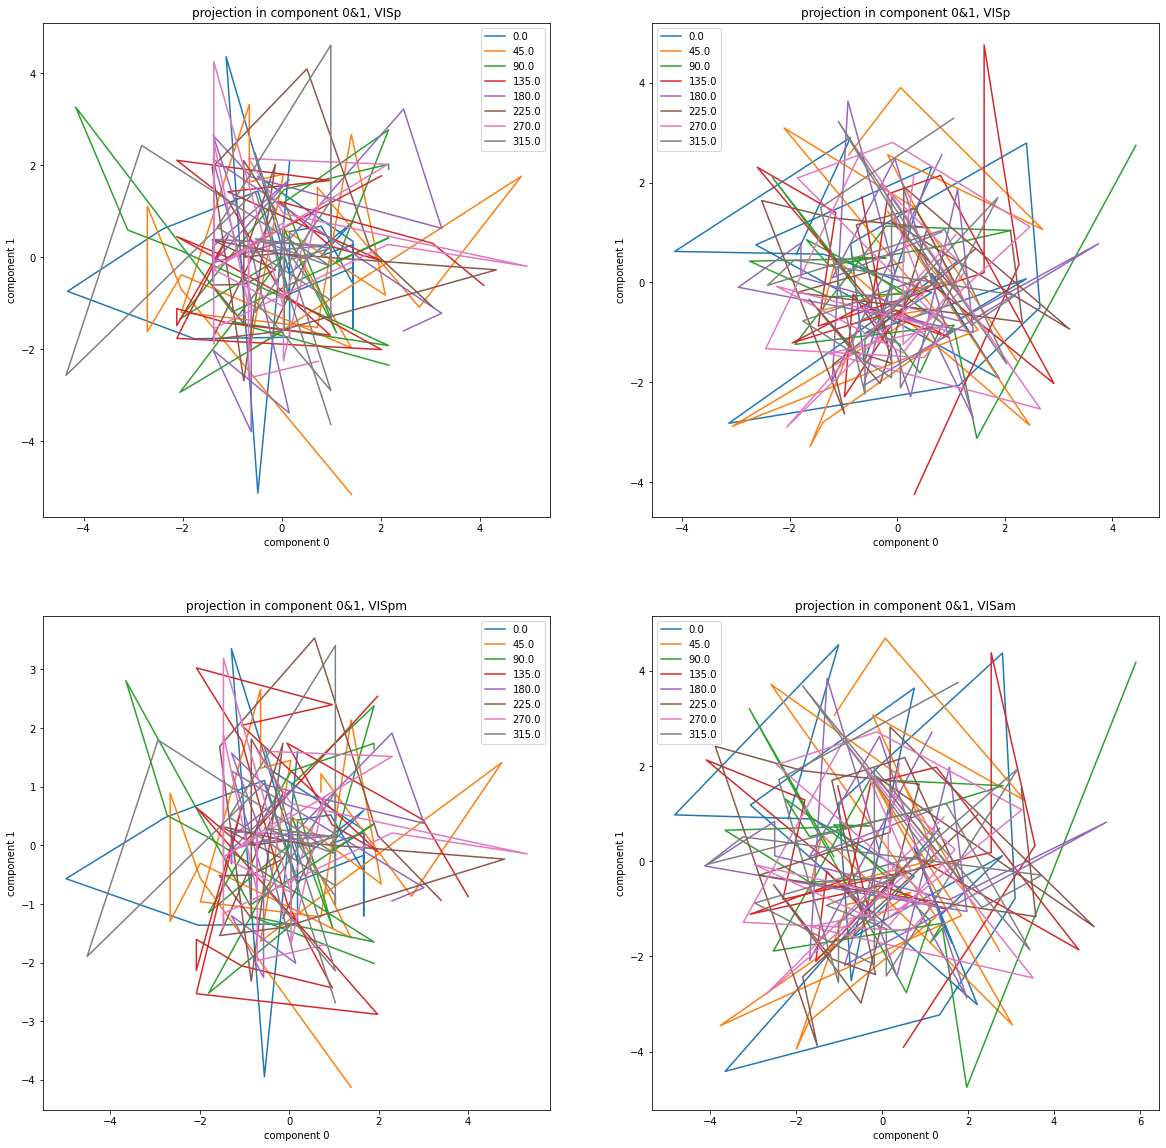

In [101]:

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0][0].plot(ori_z_1_2[:, :, 0].T, ori_z_1_2[:, :, 1].T)
axes[0][0].legend(ori_list)
axes[0][0].set_title(f'projection in component 0&1, {area_1}')
axes[0][0].set_xlabel('component 0')
axes[0][0].set_ylabel('component 1')

axes[1][0].plot(ori_z_2[:, :, 0].T, ori_z_2[:, :, 1].T)
axes[1][0].legend(ori_list)
axes[1][0].set_title(f'projection in component 0&1, {area_2}')
axes[1][0].set_xlabel('component 0')
axes[1][0].set_ylabel('component 1')

axes[0][1].plot(ori_z_1_3[:, :, 0].T, ori_z_1_3[:, :, 1].T)
axes[0][1].legend(ori_list)
axes[0][1].set_title(f'projection in component 0&1, {area_1}')
axes[0][1].set_xlabel('component 0')
axes[0][1].set_ylabel('component 1')

axes[1][1].plot(ori_z_3[:, :, 0].T, ori_z_3[:, :, 1].T)
axes[1][1].legend(ori_list)
axes[1][1].set_title(f'projection in component 0&1, {area_3}')
axes[1][1].set_xlabel('component 0')
axes[1][1].set_ylabel('component 1')

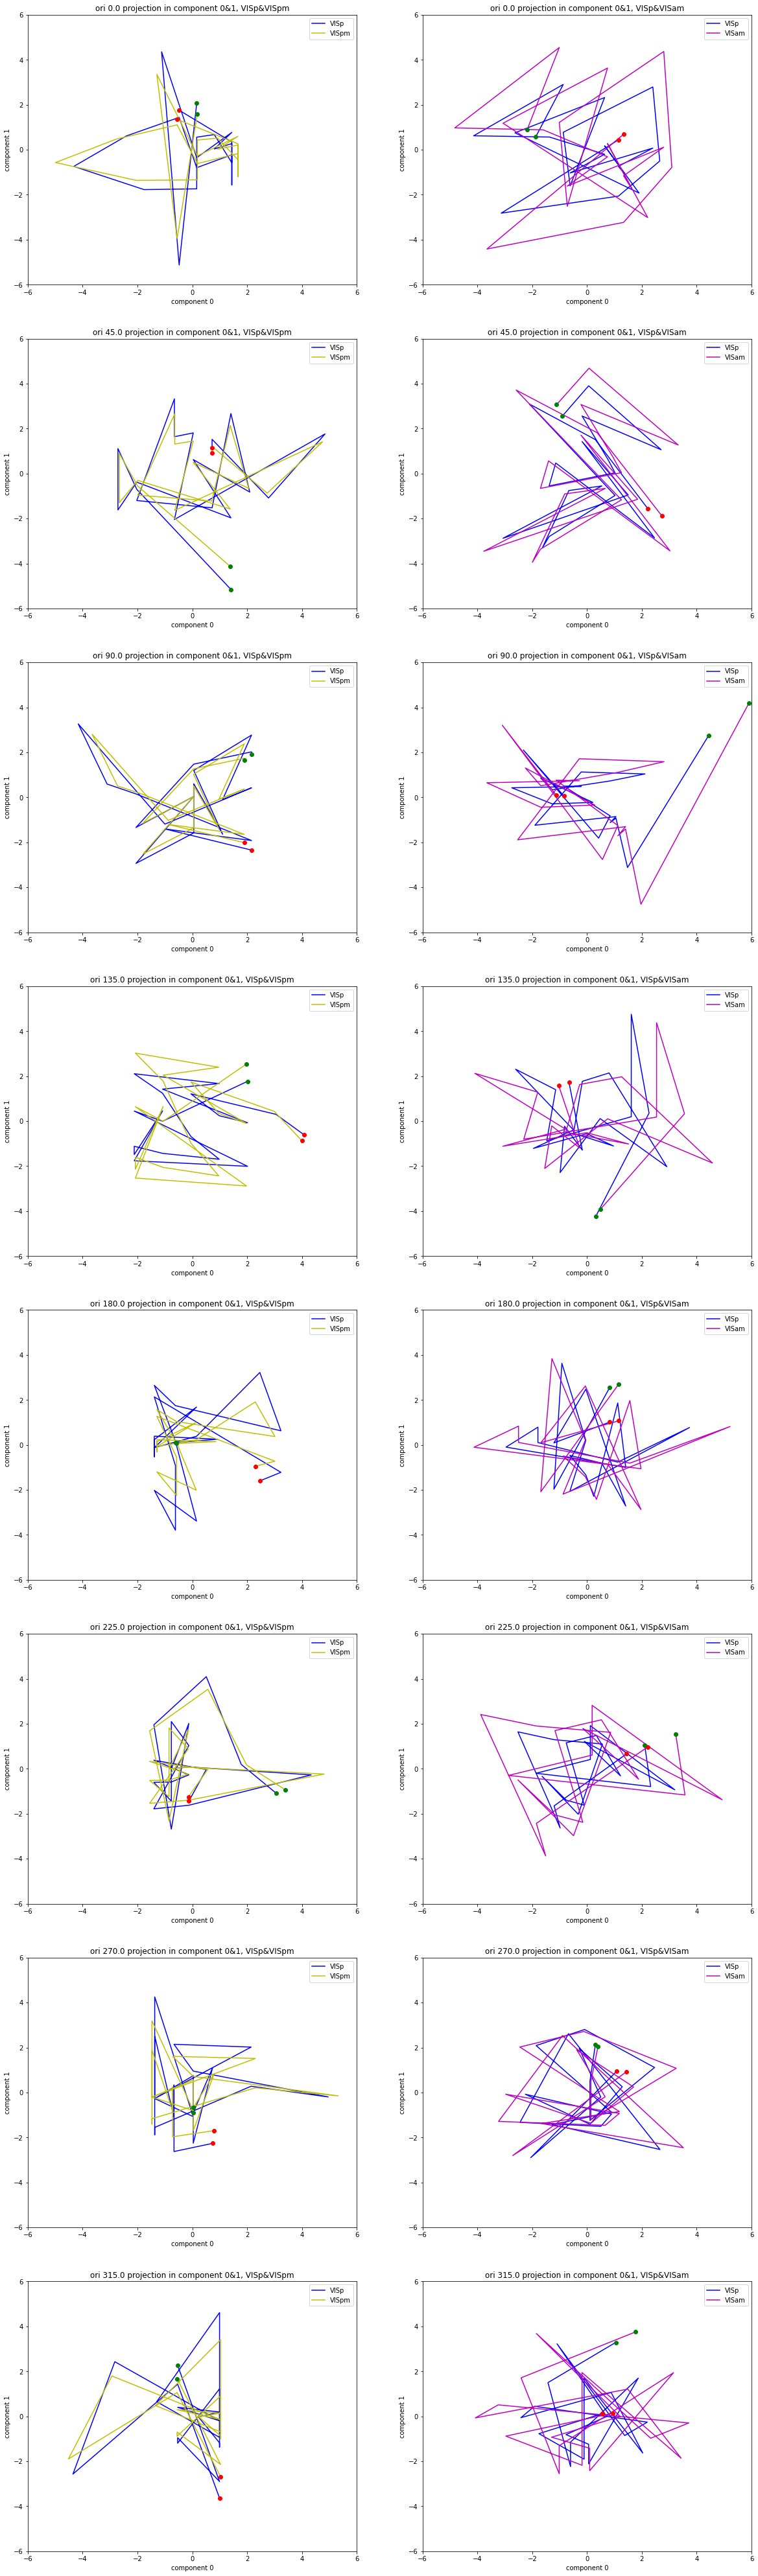

In [103]:
f, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 72))

for i, ori in enumerate(ori_list):

    axes[i][0].plot(ori_z_1_2[i, :, 0], ori_z_1_2[i, :, 1], 'b', label='VISp')
    axes[i][0].plot(ori_z_2[i, :, 0], ori_z_2[i, :, 1], 'y', label='VISpm')
    axes[i][0].legend()
    axes[i][0].set_title(f'ori {ori} projection in component 0&1, {area_1}&{area_2}')
    axes[i][0].set_xlabel('component 0')
    axes[i][0].set_ylabel('component 1')
    axes[i][0].set_xlim([-6, 6])
    axes[i][0].set_ylim([-6, 6])
    axes[i][0].plot(ori_z_1_2[i, :, 0][0], ori_z_1_2[i, :, 1][0], 'og')
    axes[i][0].plot(ori_z_1_2[i, :, 0][-1], ori_z_1_2[i, :, 1][-1], 'or')
    axes[i][0].plot(ori_z_2[i, :, 0][0], ori_z_2[i, :, 1][0], 'og')
    axes[i][0].plot(ori_z_2[i, :, 0][-1], ori_z_2[i, :, 1][-1], 'or')

    axes[i][1].plot(ori_z_1_3[i, :, 0], ori_z_1_3[i, :, 1], 'b', label='VISp')
    axes[i][1].plot(ori_z_3[i, :, 0], ori_z_3[i, :, 1], 'm', label='VISam')
    axes[i][1].legend()
    axes[i][1].set_title(f'ori {ori} projection in component 0&1, {area_1}&{area_3}')
    axes[i][1].set_xlabel('component 0')
    axes[i][1].set_ylabel('component 1')
    axes[i][1].set_xlim([-6, 6])
    axes[i][1].set_ylim([-6, 6])
    axes[i][1].plot(ori_z_1_3[i, :, 0][0], ori_z_1_3[i, :, 1][0], 'og')
    axes[i][1].plot(ori_z_1_3[i, :, 0][-1], ori_z_1_3[i, :, 1][-1], 'or')
    axes[i][1].plot(ori_z_3[i, :, 0][0], ori_z_3[i, :, 1][0], 'og')
    axes[i][1].plot(ori_z_3[i, :, 0][-1], ori_z_3[i, :, 1][-1], 'or')

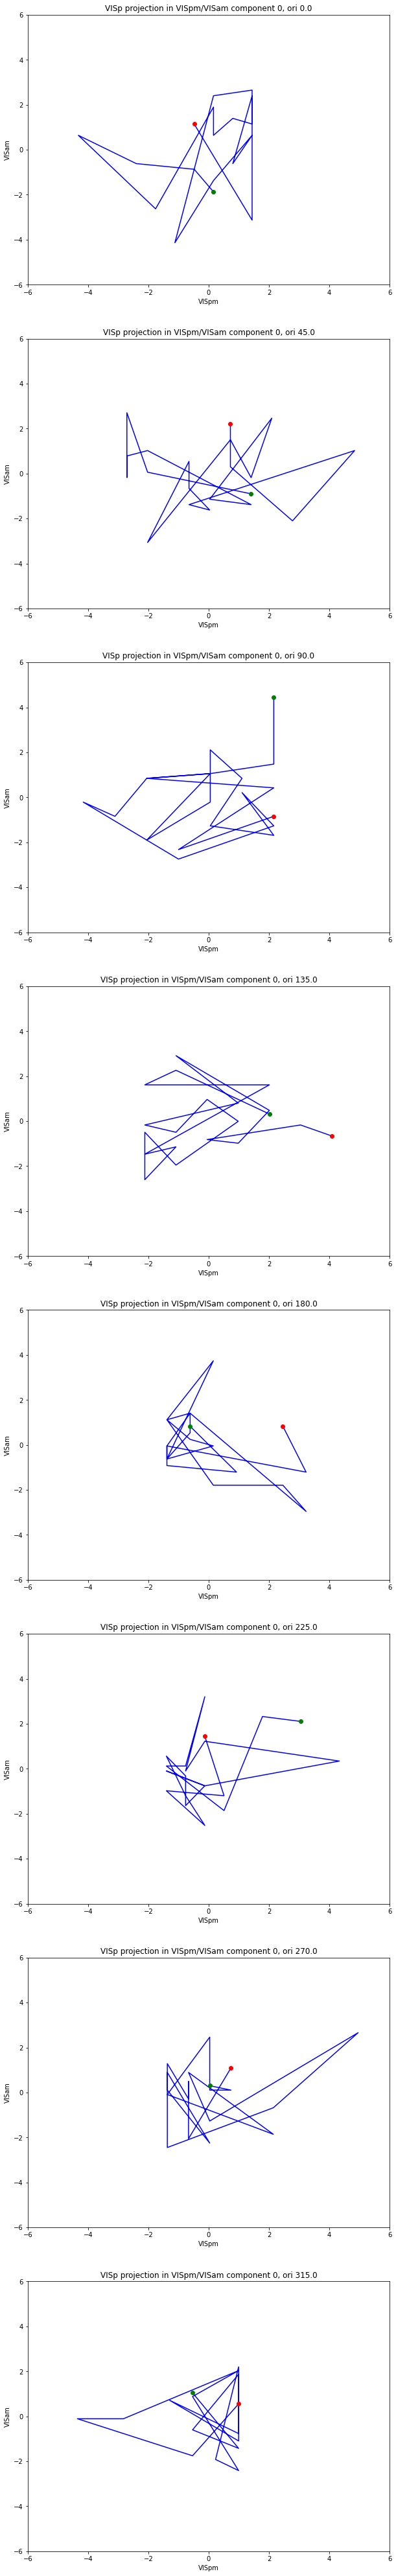

In [106]:
f, axes = plt.subplots(nrows=8, figsize=(10, 72))

for i, ori in enumerate(ori_list):

    axes[i].plot(ori_z_1_2[i, :, 0], ori_z_1_3[i, :, 0], 'b')

    axes[i].set_title(f'{area_1} projection in {area_2}/{area_3} component 0, ori {ori}')
    axes[i].set_xlabel(f'{area_2}')
    axes[i].set_ylabel(f'{area_3}')
    axes[i].set_xlim([-6, 6])
    axes[i].set_ylim([-6, 6])
    axes[i].plot(ori_z_1_2[i, :, 0][0], ori_z_1_3[i, :, 0][0], 'og')
    axes[i].plot(ori_z_1_2[i, :, 0][-1], ori_z_1_3[i, :, 0][-1], 'or')